# Assignment 4: Classification

This assignment needs assign4_train.csv and assign4_test.csv. assign4_train.csv is for training and assign4_test.csv is for test. Both of them have samples in the following format:

|label | text |
|------|------|
|1|  I must admit that I'm addicted to "Version 2.0...|
|0|  I think it's such a shame that an enormous tal...|
|1|  The Sunsout No Room at The Inn Puzzle has oddl...|
|...|...|


## Q1 Classification 

Write a function **classify** to conduct a classification experiement as follows: 
1. Take the training and testing file names (strings) as inputs, i.e. classify (training_file, testing_file). 
2. Classify text samples in the training file using **Linear SVM** as follows: 
   - a. First apply grid search with **6-fold cross validation** to find the best values for parameters **min_df**, **stop_words**, and **C** of Linear SVM that are used the modeling pipeline. Use f1-macro as the scoring metric to select the best parameter values. Potential values for these parameters are: 
      * min_df' : [1,2,3]
      * stop_words' : [None,"english"]
      * C: [0.5,1,5] 
   - b. Using the best parameter values, **train a Linear SVM with all samples** in the training file 
3. Test the classifier created in Step 2.b using the test file. Report the testing performance as: 
   - Precision, recall, and f1-score of each label 
   - Treat label 1 as the positive class, plot precision-recall curve and ROC curve, and calculate AUC, Average Precision (sklearn.metrics.average_precision_score). Note, LinearSVC does not ouput probability, but you can use **decision_function** to calculate AUC (https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function) 
4. Your function "classify" has no return. However, when this function is called, the best parameter values from grid search is printed and the testing performance from Step 3 is printed. 

## Q2. How to determine **K** in k-fold cross validation?  

This question will use assign4_train.csv dataset. Use this experiment to find the best **k** for k-fold cross validation.

Write a function "K_fold_CV" as follows:
- Take the full file name path string for a dataset as an input, e.g. K_fold_CV(dataset_file). 
- Create tf-idf matrix using TfidfVectorizer 
- Conduct k-fold cross validation for different $k$ values varying from 2 to 20. For each $k$, do the following:
    1. train a classifier using **multinomial Naive Bayes** model with k-fold cross validation 
    2. train a classifier using **linear support vector machine** model with k-fold cross validation 
    3. for each classifier, collect the average AUC across $k$ folds (treat label 1 as the positive class). Hint, for binary classification, you can set "roc_auc" as the value of "metric" parameter of function "cross_validate". 
- Plot a line chart to show **the relationship between sample size and AUC**  
- Write your analysis in a **separate pdf file (not in code)** on the following: 
  - How does $k$ affect model performance on evaluation sets? 
  - By varying $k$, you also change sample size for training. How can the sample size affect model performance? 
- There is no return for this function, but the charts should be plotted.

## Q3 (Bonus): Ensemble Models by Stacking

An emsemble model combines decisions from multiple models to improve the overall performance. This question askes you to implement an emsemble model by stacking. The details of this technique and sample code can be found at https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/. 

Define a function **stacking** to achieve the following:
- Take the training and testing file names (strings) as inputs, i.e. stacking(training_file, testing_file). 
- Train Naive Bayes and Linear SVM using 6-fold cross validation as two base models
- Following the procedure for stacking, train a decision tree or random forest as the top model using the predictions from the base models
- Test the ensemble model performance using the testing dataset and print out precision, recall and F-1 score. 

This function has not return. Note, this ensemble model may not give you a better performance than base models. Just take this chance to learn how to create ensemble models by stacking. This is a very useful technique.

In [100]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,precision_recall_curve
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

# add import statements

In [101]:
# Q1

def classify(train_file, test_file):
    
    train=pd.read_csv(train_file)
    test=pd.read_csv(test_file)

# build a pipeline which does two steps all together:
# (1) generate tfidf, and (2) train classifier
# each step is named, i.e. "tfidf", "clf"

    text_clf = Pipeline([('tfidf', TfidfVectorizer()),('clf', LinearSVC())])

# set the range of parameters to be tuned
# each parameter is defined as 
# <step name>__<parameter name in step>
# e.g. min_df is a parameter of TfidfVectorizer()
# "tfidf" is the name for TfidfVectorizer()
# therefore, 'tfidf__min_df' is the parameter in grid search

    parameters = {'tfidf__min_df':[1, 2,3],
              'tfidf__stop_words':[None,"english"],
              'clf__C': [0.5,1.0,5.0],
    }

# the metric used to select the best parameters
    metric =  "f1_macro"

# GridSearch also uses cross validation
    gs_clf = GridSearchCV\
    (text_clf, param_grid=parameters, \
     scoring=metric, cv=6)

# due to data volume and large parameter combinations
# it may take long time to search for optimal parameter combination
# you can use a subset of data to test
    gs_clf = gs_clf.fit(train["text"], train["label"])
    
    
    for param_name in gs_clf.best_params_:
        print(param_name,": ",gs_clf.best_params_[param_name])

    print("best f1 score:", gs_clf.best_score_)
    
    grid_predictions = gs_clf.predict(test["text"])
    
    print(classification_report(test["label"], grid_predictions)) 
    
    auc_clf=gs_clf.fit(train["text"], train["label"]).decision_function(test['text'])
    
# compute fpr/tpr by different thresholds
# positive class has label "1"
    fpr, tpr, thresholds = roc_curve(test["label"], auc_clf, \
                                 pos_label=1)

    # calculate auc

    AUC = auc(fpr, tpr)
    
    print("AUC: {0:.3f}".format(AUC))   
    
    plt.figure();
    plt.plot(fpr, tpr, color='darkorange', lw=2);
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('AUC of Naive Bayes Model');
    plt.show();
             
    precision, recall, thresholds = precision_recall_curve(test["label"], \
                                auc_clf, pos_label=1)
    
    apc = average_precision_score(test["label"], auc_clf)   
    print("Average Precision: {0:.3f}".format(apc))
    

    plt.figure();
    plt.plot(recall, precision, color='darkorange', lw=2);
    plt.xlim([0.0, 1.0]);
    plt.ylim([0.0, 1.05]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Precision_Recall_Curve of Naive Bayes Model');
    plt.show();
    return None
#classify("/Users/parthxparab/Documents/Fall 2019/BIA660/Lab4/dataset/assign4_train.csv",\
#         "/Users/parthxparab/Documents/Fall 2019/BIA660/Lab4/dataset/assign4_test.csv")

In [102]:
# Q2

def K_fold_CV(train_file):
    train=pd.read_csv(train_file)
    tfidf_vect = TfidfVectorizer(stop_words="english") 

    # generate tfidf matrix
    dtm= tfidf_vect.fit_transform(train["text"])
    
    metrics = ['roc_auc']

    svm = []
    nb = []
    clf = MultinomialNB()
    clf1 = LinearSVC()
#clf = MultinomialNB(alpha=0.5)

    for i in range(2,21):

        cvNB = cross_validate(clf, dtm, train["label"], \
                        scoring=metrics, cv=i, \
                        return_train_score=True)
        nb.append(np.mean(cvNB['test_roc_auc']))
        cvSVC = cross_validate(clf1, dtm, train["label"], \
                        scoring=metrics, cv=i, \
                        return_train_score=True)
        svm.append(np.mean(cvSVC['test_roc_auc']))

    plt.plot(range(2,21),nb,color='orange')
    plt.plot(range(2,21),svm,color='blue')
    plt.xlabel('K')
    plt.xlim((2, 20))  
    plt.legend(['nb','svm'])
    plt.show()

    
    return None
#K_fold_CV("/Users/parthxparab/Documents/Fall 2019/BIA660/Lab4/dataset/assign4_train.csv")

In [103]:
def stacking(train_file, test_file):
    
    return None
    
    

Q1
clf__C :  0.5
tfidf__min_df :  1
tfidf__stop_words :  None
best f1 score: 0.8045970021016776
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       248
           1       0.82      0.75      0.78       252

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500

AUC: 0.881


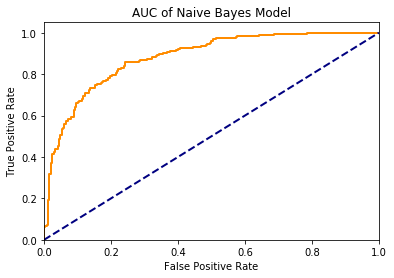

Average Precision: 0.871


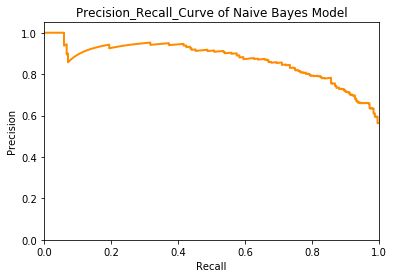


Q2


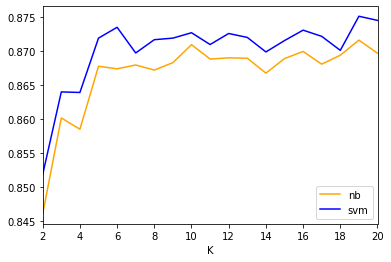

In [104]:
if __name__ == "__main__":  
    # Question 1
    print("Q1")
    classify("/Users/parthxparab/Documents/Fall 2019/BIA660/Lab4/dataset/assign4_train.csv",\
         "/Users/parthxparab/Documents/Fall 2019/BIA660/Lab4/dataset/assign4_test.csv")
    
    # Test Q2
    print("\nQ2")
    K_fold_CV("/Users/parthxparab/Documents/Fall 2019/BIA660/Lab4/dataset/assign4_train.csv")
    
    # Test Q3
  #  print("\nQ3")
  #  stacking("../../dataset/assign4_train.csv",\
  #       "../../dataset/assign4_test.csv")
   